# IS319 - Deep Learning

## TP2 - Dogs vs. cats (PyTorch)

Credits: Baptiste Pesquet

![Woof Meow](woof_meow.jpg)

In this TP, the goal is to train neural networks to classify images of dogs and cats, using the PyTorch library.

The images used in this TP are extracted from the [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/) dataset available on Kaggle, which contains 25000 images. First, we use a subset of 2000 images to decrease training time, for educational purposes. Later on, you can experiment with the full dataset using a GPU.

Most questions are open-ended: feel free to experiment with different settings. **Remember to analyze and explain what you are doing in additional cells.**

## Environment setup

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import random

In [2]:
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.models as models

PyTorch version: 2.4.1+cu124


## 1. Load and explore the dataset

In [3]:
# Downloading our example data, a .zip of 2000 JPG pictures, and extracting it locally in `/tmp`
!wget --no-check-certificate --no-clobber \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

# Extracting zip file to the base directory `/tmp/cats_and_dogs_filtered`
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# Directories with training/validation cat/dogs pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

# Display the sizes of our dataset
print(f'Number of train cat images: {len(os.listdir(train_cats_dir))}')
print(f'Number of train dog images: {len(os.listdir(train_dogs_dir))}')
print(f'Number of valid cat images: {len(os.listdir(valid_cats_dir))}')
print(f'Number of valid dog images: {len(os.listdir(valid_dogs_dir))}')

# Display some images files for cats and dogs
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])
train_dog_fnames = os.listdir(train_dogs_dir)
print(train_dog_fnames[:10])

--2024-11-12 14:12:50--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.213.91, 172.217.20.187, 142.250.179.91, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.213.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   388KB/s    in 3m 36s  

2024-11-12 14:16:27 (310 KB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Number of train cat images: 1000
Number of train dog images: 1000
Number of valid cat images: 500
Number of valid dog images: 500
['cat.127.jpg', 'cat.126.jpg', 'cat.125.jpg', 'cat.124.jpg', 'cat.123.jpg', 'cat.122.jpg', 'cat.121.jpg', 'cat.120.jpg', 'cat.119.jpg', 'cat.118.jpg']
['dog.127.jpg', 'dog.126.jpg', 'dog.125.jpg', 

**(Question)** Display some images of cats and dogs from the train set and the validation set.

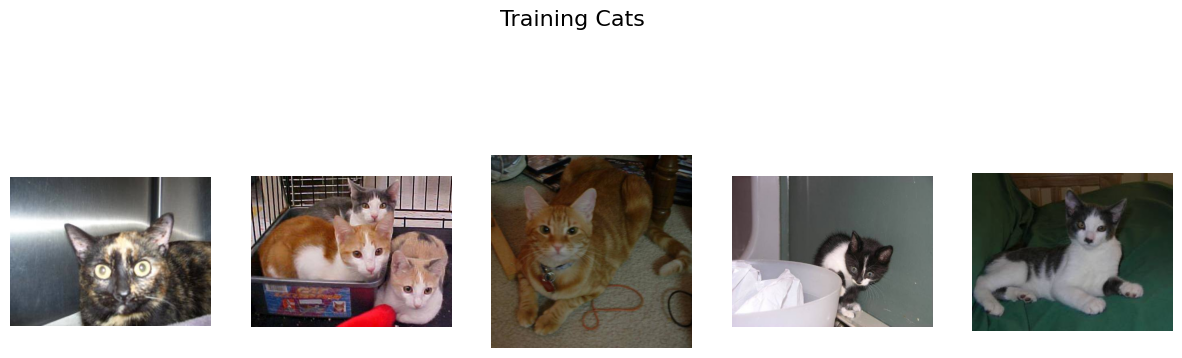

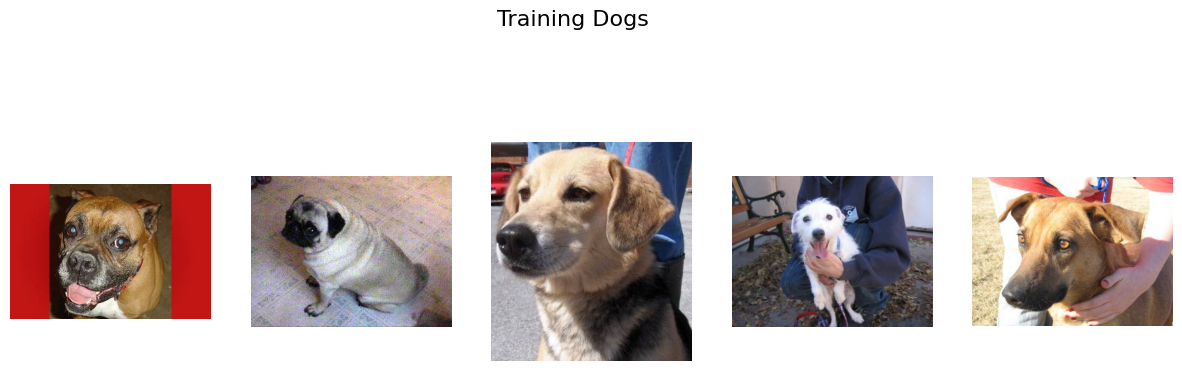

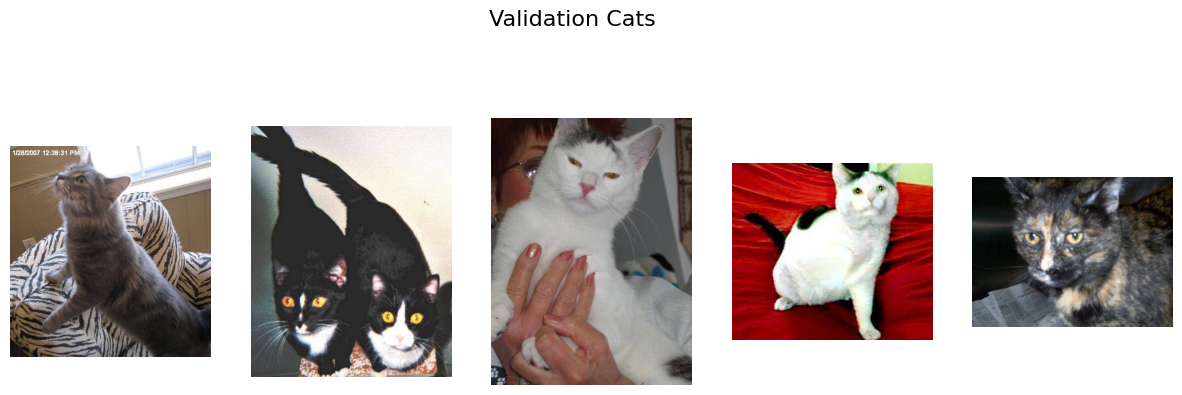

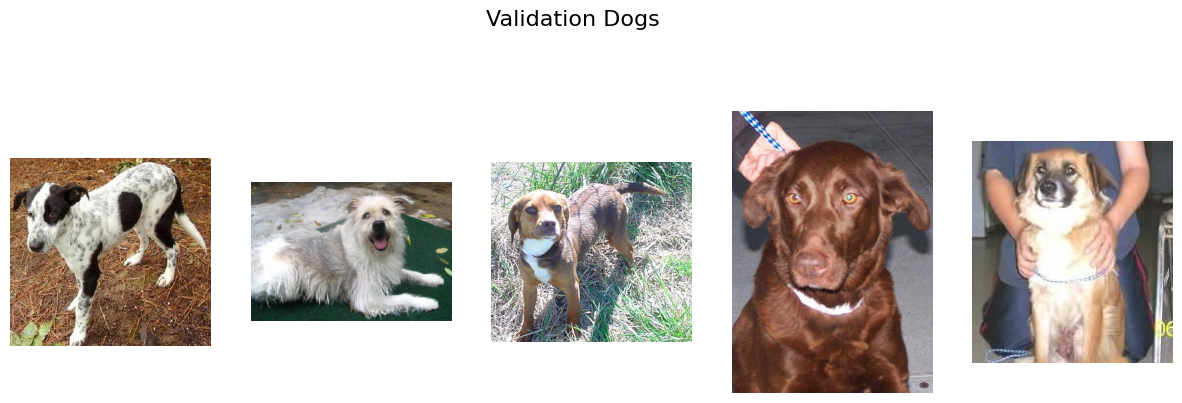

In [4]:
def display_images(image_paths, title, n=5):
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)
    for i, image_path in enumerate(image_paths[:n]):
        img = Image.open(image_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

train_cat_images = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)[:5]]
train_dog_images = [os.path.join(train_dogs_dir, fname) for fname in os.listdir(train_dogs_dir)[:5]]
valid_cat_images = [os.path.join(valid_cats_dir, fname) for fname in os.listdir(valid_cats_dir)[:5]]
valid_dog_images = [os.path.join(valid_dogs_dir, fname) for fname in os.listdir(valid_dogs_dir)[:5]]

display_images(train_cat_images, "Training Cats")
display_images(train_dog_images, "Training Dogs")
display_images(valid_cat_images, "Validation Cats")
display_images(valid_dog_images, "Validation Dogs")

## 2. Prepare the dataset

**(Question)** Following the documentation, create a custom `torch.utils.data.Dataset` class to handle your train and validation datasets. Allow this class to resize images and normalize them. Then, create a `DataLoader` for train and validation datasets to handle shuffling and batches.

In [5]:
class CatsAndDogsDataset(torch.utils.data.Dataset):
    def __init__(self, cats_dir, dogs_dir, prob_to_transform=1, transform=None, target_transform=None):
        self.img_labels = [0] * len(os.listdir(cats_dir)) + [1] * len(os.listdir(dogs_dir))
        self.img_paths = [os.path.join(cats_dir, fname) for fname in os.listdir(cats_dir)]
        self.img_paths += [os.path.join(dogs_dir, fname) for fname in os.listdir(dogs_dir)]
        self.prob_to_transform = prob_to_transform
        self.base_transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
        if transform is None:
            self.transform = self.base_transform
        else:
            self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.img_labels[idx]
        image = Image.open(img_path).convert("RGB")  # Ensure it's in RGB format
        if random.random() < self.prob_to_transform:
            image = self.transform(image)
        else:
            image = self.base_transform(image)
        return image, label

training_data = CatsAndDogsDataset(train_cats_dir, train_dogs_dir)
validation_data = CatsAndDogsDataset(valid_cats_dir, valid_dogs_dir)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True)

## 3. Training CNN models

**(Question)** Create a CNN classification model able to be trained on your dataset. Show the model and its number of parameters.

In [6]:
class CatDogCNN(nn.Module):
    def __init__(self):
        super(CatDogCNN, self).__init__()
        
        # Convolutional layers
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully connected layers
        self.fc_layer = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x
    
model = CatDogCNN()
print(model)
print(f"Total number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

CatDogCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1, bias=True)
    (3): Sigmoid()
  )
)
Total number of trainable parameters: 8778049


**(Question)** Using PyTorch, implement a training loop with your model and an appropriate loss function.

In [7]:
def training_loop(model, train_dataloader, validation_dataloader, criterion=nn.BCELoss(), optimizer=optim.Adam, lr=0.001, num_epochs=10):
    optimizer = optimizer(model.parameters(), lr=lr)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"--- Using {device} ---")
    model = model.to(device)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train() 
        running_loss = 0.0
        
        for images, labels in train_dataloader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            
            # Calculate loss
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Accumulate loss for monitoring
            running_loss += loss.item() * images.size(0)
        
        # Calculate average loss over an epoch
        avg_train_loss = running_loss / len(train_dataloader.dataset)
        
        # Validation phase (without gradient updates)
        model.eval()
        train_correct = 0
        val_loss = 0.0
        val_correct = 0
        
        with torch.no_grad():
            for images, labels in validation_dataloader:
                images, labels = images.to(device), labels.to(device)
                labels = labels.float().unsqueeze(1)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Accumulate validation loss
                val_loss += loss.item() * images.size(0)
                
                # Calculate accuracy
                preds = (outputs >= 0.5).float()  # Convert to binary predictions (0 or 1)
                val_correct += (preds == labels).sum().item()

            for images, labels in train_dataloader:
                images, labels = images.to(device), labels.to(device)
                labels = labels.float().unsqueeze(1)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Calculate accuracy
                preds = (outputs >= 0.5).float()  # Convert to binary predictions (0 or 1)
                train_correct += (preds == labels).sum().item()

        # Calculate average loss and accuracy
        train_accuracy = train_correct / len(train_dataloader.dataset)

        avg_val_loss = val_loss / len(validation_dataloader.dataset)
        val_accuracy = val_correct / len(validation_dataloader.dataset)
        
        # Print progress
        print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Train Loss: {avg_train_loss:.4f}, "
            f"Validation Loss: {avg_val_loss:.4f}, "
            f"Validation Accuracy: {val_accuracy:.4f}")
        
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

    return train_losses, train_accuracies, val_losses, val_accuracies

**(Question)** Train your model. Monitor train and validation accuracy. Analyze your results.

--- Using cuda ---
Epoch [1/10], Train Loss: 0.6944, Validation Loss: 0.6746, Validation Accuracy: 0.6050
Epoch [2/10], Train Loss: 0.6641, Validation Loss: 0.6595, Validation Accuracy: 0.5820
Epoch [3/10], Train Loss: 0.6413, Validation Loss: 0.6686, Validation Accuracy: 0.5930
Epoch [4/10], Train Loss: 0.6059, Validation Loss: 0.6038, Validation Accuracy: 0.6880
Epoch [5/10], Train Loss: 0.5628, Validation Loss: 0.5913, Validation Accuracy: 0.6910
Epoch [6/10], Train Loss: 0.5108, Validation Loss: 0.5715, Validation Accuracy: 0.7200
Epoch [7/10], Train Loss: 0.4874, Validation Loss: 0.5486, Validation Accuracy: 0.7350
Epoch [8/10], Train Loss: 0.4377, Validation Loss: 0.5499, Validation Accuracy: 0.7310
Epoch [9/10], Train Loss: 0.3995, Validation Loss: 0.7222, Validation Accuracy: 0.6670
Epoch [10/10], Train Loss: 0.3750, Validation Loss: 0.6069, Validation Accuracy: 0.7250


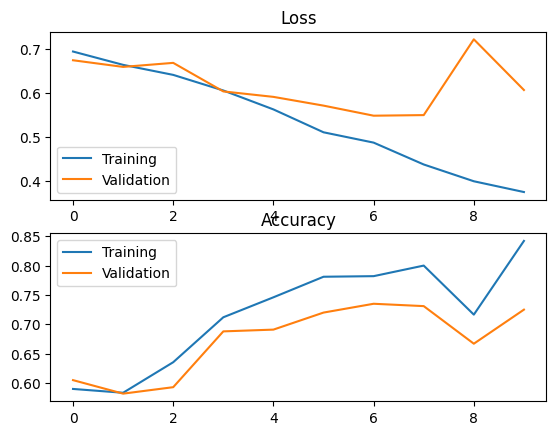

In [8]:
model = CatDogCNN()
num_epochs = 10
train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train_dataloader, validation_dataloader, num_epochs=num_epochs)

X = np.arange(num_epochs)
fig, ax = plt.subplots(2)
ax[0].plot(X, train_losses, label="Training")
ax[0].plot(X, val_losses, label="Validation")
ax[0].set_title("Loss")
ax[0].legend()

ax[1].plot(X, train_accuracies, label="Training")
ax[1].plot(X, val_accuracies, label="Validation")
ax[1].set_title("Accuracy")
ax[1].legend()

From epoch 5, the validation loss appears to stabilize while the training loss continues to decrease. This pattern suggests potential overfitting, as the model may be learning details specific to the training set without improving its performance on unseen data.

**(Question)** Make sure your code is using a GPU if one is available. Modify your code accordingly, if necessary. What kind of speedup do you observe? 

- GPU: 10 s/epoch
- CPU: 40 s/epoch

Times 4

## 4. Preventing overfitting

**(Question)** Experiment with various deep learning techniques to prevent overfitting.

Some suggested strategies are:

- Adding data augmentation: possible transformations are random (horizontal) flips, rotations, translations, crops, and zooms
    - (When using data augmentation, it is always good to visualize some of your transformations)
- Adding dropout to the classification part
- Adding appropriate batch normalization layers in different parts of the network

In [9]:
class CatDogCNN(nn.Module):
    def __init__(self):
        super(CatDogCNN, self).__init__()
        
        # Convolutional layers
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Fully connected layers
        self.fc_layer = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layer(x)
        return x
    
model = CatDogCNN()
print(model)
print(f"Total number of trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

CatDogCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Linear(in_features=16384, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=1, bias=True)
    (4): Sigmoid()
  )
)
Total number of trainab

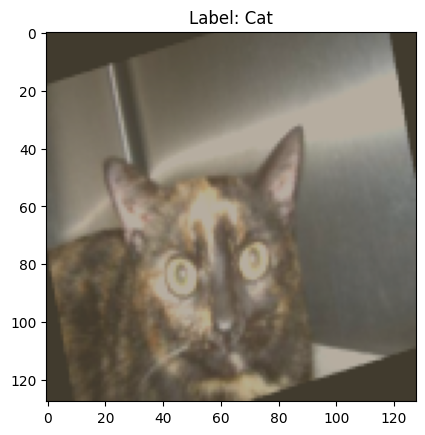

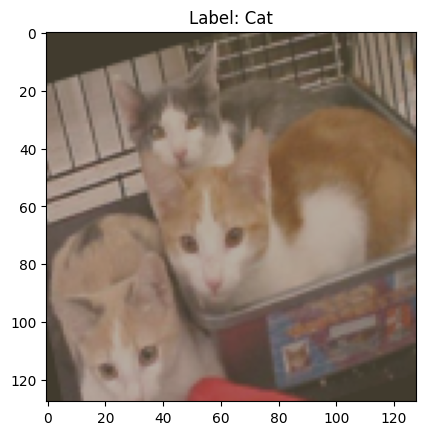

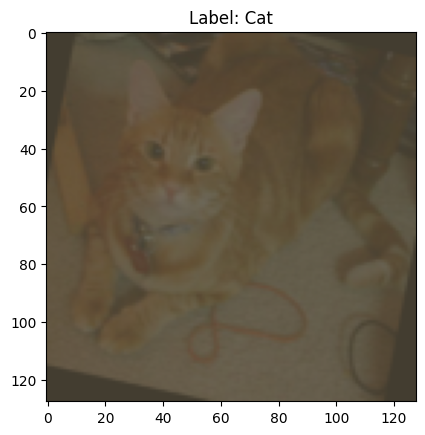

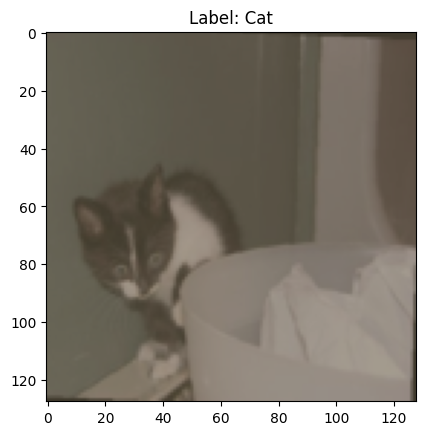

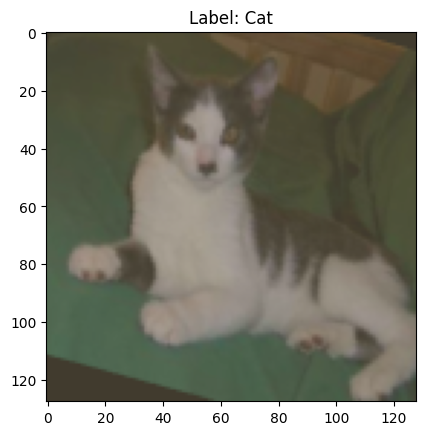

In [10]:
# Define data augmentation transformations for training data
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),  # Small rotation
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random cropping and resizing
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jitter
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Display some augmented images to verify transformations
def visualize_augmentations(dataset, num_images=5):
    for i in range(num_images):
        image, label = dataset[i]
        image = image.permute(1, 2, 0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Undo normalization for visualization
        plt.imshow(image)
        plt.title(f"Label: {'Cat' if label == 0 else 'Dog'}")
        plt.show()

train_dataset = CatsAndDogsDataset(train_cats_dir, train_dogs_dir, transform=train_transform)
valid_dataset = CatsAndDogsDataset(valid_cats_dir, valid_dogs_dir)

# Visualize augmented training images
visualize_augmentations(train_dataset)

**(Question)** Train your model with deep learning techniques. Analyze the results and compare with the previous model.

In [11]:
model = CatDogCNN()
num_epochs = 40

training_data = CatsAndDogsDataset(train_cats_dir, train_dogs_dir, prob_to_transform=0.4, transform=train_transform)
validation_data = CatsAndDogsDataset(valid_cats_dir, valid_dogs_dir)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=64, shuffle=True)

train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train_dataloader, validation_dataloader, num_epochs=num_epochs)

--- Using cuda ---
Epoch [1/40], Train Loss: 0.6987, Validation Loss: 0.6901, Validation Accuracy: 0.5220
Epoch [2/40], Train Loss: 0.6850, Validation Loss: 0.7270, Validation Accuracy: 0.5180
Epoch [3/40], Train Loss: 0.6992, Validation Loss: 0.6878, Validation Accuracy: 0.5680
Epoch [4/40], Train Loss: 0.6853, Validation Loss: 0.6760, Validation Accuracy: 0.5780
Epoch [5/40], Train Loss: 0.6573, Validation Loss: 0.6992, Validation Accuracy: 0.5770
Epoch [6/40], Train Loss: 0.6324, Validation Loss: 0.6620, Validation Accuracy: 0.6080
Epoch [7/40], Train Loss: 0.6121, Validation Loss: 0.6737, Validation Accuracy: 0.6380
Epoch [8/40], Train Loss: 0.6085, Validation Loss: 0.5898, Validation Accuracy: 0.6850
Epoch [9/40], Train Loss: 0.5888, Validation Loss: 0.5922, Validation Accuracy: 0.6910
Epoch [10/40], Train Loss: 0.5610, Validation Loss: 0.5543, Validation Accuracy: 0.7160
Epoch [11/40], Train Loss: 0.5415, Validation Loss: 0.6042, Validation Accuracy: 0.6810
Epoch [12/40], Train L

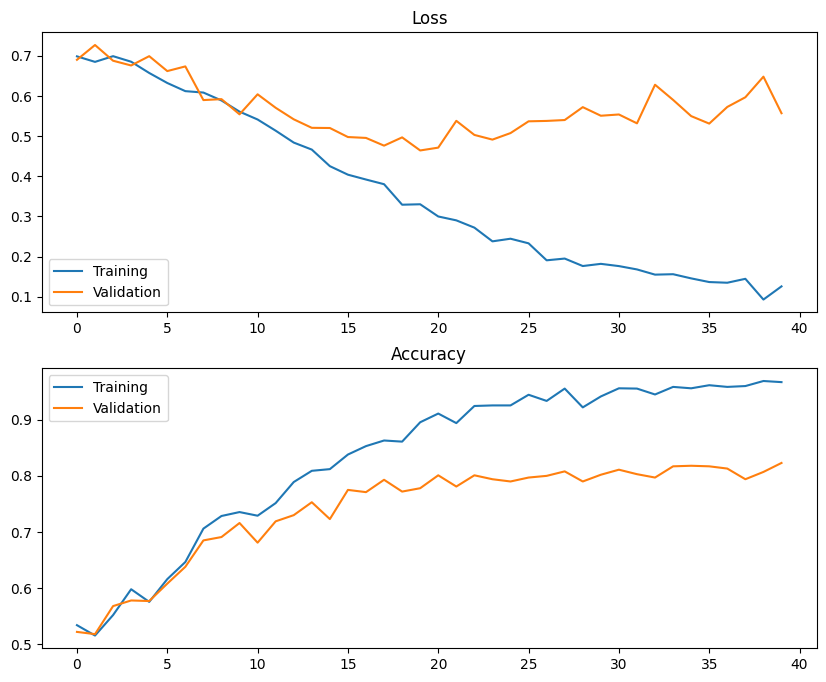

In [12]:
X = np.arange(num_epochs)
fig, ax = plt.subplots(2, figsize=(10, 8))
ax[0].plot(X, train_losses, label="Training")
ax[0].plot(X, val_losses, label="Validation")
ax[0].set_title("Loss")
ax[0].legend()

ax[1].plot(X, train_accuracies, label="Training")
ax[1].plot(X, val_accuracies, label="Validation")
ax[1].set_title("Accuracy")
ax[1].legend()
plt.show()

As we can see, the validation loss increases after epoch 20 but the validation accuracy too. It could be due to the dropout which here prevents from overfitting.

## 5. Finetuning a pretrained model

**(Question)** Load the feature extraction part of VGG16 model. The feature extraction part corresponds to the CNN part, without the MLP classifier at the end.

In [13]:
vgg16 = models.vgg16(pretrained=True)

feature_extractor = torch.nn.Sequential(*list(vgg16.children())[:-1])  # Removes the classifier

print(feature_extractor)

num_params = sum(p.numel() for p in feature_extractor.parameters() if p.requires_grad)
print(f'Number of trainable parameters in the feature extractor: {num_params}')

/home/rpierre002/AI-option/global-venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rpierre002/AI-option/global-venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

**(Question)** Add a custom MLP classifier on top of the VGG16 feature extraction part.

In [14]:
class VGG16WithMLP(nn.Module):
    def __init__(self, num_classes):
        super(VGG16WithMLP, self).__init__()
        self.feature_extractor = feature_extractor

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        with torch.no_grad():
            x = self.feature_extractor(x)
        x = self.flatten(x)
        x = nn.ReLU()(self.fc1(x))
        x = self.fc2(x)
        return x

num_classes = 2
model3 = VGG16WithMLP(num_classes)

print(model3)

num_params = sum(p.numel() for p in model3.parameters() if p.requires_grad)
print(f'Number of trainable parameters in the model: {num_params}')

VGG16WithMLP(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=T

**(Question)** Train your model. Analyze your results and compare with your initial model trained from scratch.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_vgg16_mlp = VGG16WithMLP(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg16_mlp.parameters(), lr=0.01)

def train_model_vgg16_mlp(model, train_loader, valid_loader, num_epochs=10, device=device):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        model.eval()
        running_val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()
                _, val_predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (val_predicted == labels).sum().item()

        val_epoch_loss = running_val_loss / len(valid_loader)
        val_epoch_accuracy = val_correct / val_total
        valid_losses.append(val_epoch_loss)
        valid_accuracies.append(val_epoch_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:4f}, "
              f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:4f}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

train_losses_vgg, valid_losses_vgg, train_accuracies_vgg, valid_accuracies_vgg = train_model_vgg16_mlp(
    model_vgg16_mlp, train_dataloader, validation_dataloader, num_epochs=40, device=device)

Epoch [1/40], Train Loss: 7.1352, Train Accuracy: 0.878000, Validation Loss: 0.2647, Validation Accuracy: 0.935000
Epoch [2/40], Train Loss: 0.1133, Train Accuracy: 0.966000, Validation Loss: 0.1626, Validation Accuracy: 0.957000
Epoch [3/40], Train Loss: 0.0829, Train Accuracy: 0.970000, Validation Loss: 0.1194, Validation Accuracy: 0.960000
Epoch [4/40], Train Loss: 0.0540, Train Accuracy: 0.979500, Validation Loss: 0.1533, Validation Accuracy: 0.950000
Epoch [5/40], Train Loss: 0.0368, Train Accuracy: 0.988000, Validation Loss: 0.1402, Validation Accuracy: 0.964000
Epoch [6/40], Train Loss: 0.0220, Train Accuracy: 0.991500, Validation Loss: 0.1710, Validation Accuracy: 0.959000
Epoch [7/40], Train Loss: 0.0259, Train Accuracy: 0.990000, Validation Loss: 0.2314, Validation Accuracy: 0.957000
Epoch [8/40], Train Loss: 0.0668, Train Accuracy: 0.984000, Validation Loss: 0.1674, Validation Accuracy: 0.964000
Epoch [9/40], Train Loss: 0.0198, Train Accuracy: 0.992500, Validation Loss: 0.1

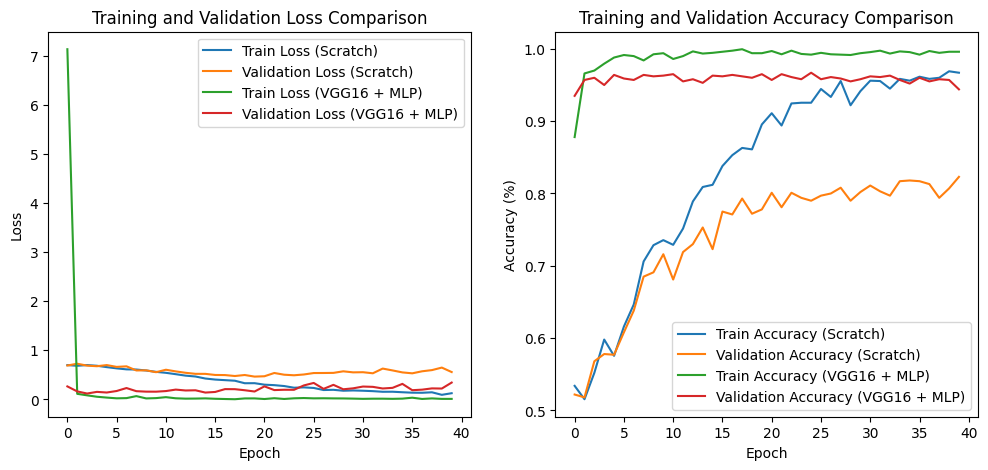

In [16]:
# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss (Scratch)')
plt.plot(val_losses, label='Validation Loss (Scratch)')
plt.plot(train_losses_vgg, label='Train Loss (VGG16 + MLP)')
plt.plot(valid_losses_vgg, label='Validation Loss (VGG16 + MLP)')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss Comparison")

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy (Scratch)')
plt.plot(val_accuracies, label='Validation Accuracy (Scratch)')
plt.plot(train_accuracies_vgg, label='Train Accuracy (VGG16 + MLP)')
plt.plot(valid_accuracies_vgg, label='Validation Accuracy (VGG16 + MLP)')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Training and Validation Accuracy Comparison")

plt.show()

VGG16 + MLP obtains the best result with a validation accuracy of 96.7. We can see that the model queeckly converges (less than 5 epochs) which is not surprising because we only train the custom MLP at the end and the VGG16's weights are pre-trained and frozen.